<a href="https://colab.research.google.com/github/fsternini/anomaly-prediction/blob/development/anomaly_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [1]:
# First, verification of Python version is completed
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [2]:
!git clone 'https://github.com/fsternini/anomaly-prediction.git'
%cd 'anomaly-prediction'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'anomaly-prediction'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 569.54 KiB | 2.21 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/anomaly-prediction
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


In [3]:
!pip install pandas scipy colab-env

  Preparing metadata (setup.py) ... done
  Created wheel for colab-env: filename=colab_env-0.2.0-py3-none-any.whl size=3806 sha256=6b412418f9a56931fb14009b16165da842848681b5153fa0aa818cda51dfb79e
  Stored in directory: /root/.cache/pip/wheels/ae/36/4f/466c2cd4db5d08f317893a920c4a0f58a81459ee3bdb136d35
Successfully built colab-env


In [4]:
from scipy.io import loadmat
from google.colab import drive
import colab_env
import os,sys
from imblearn.over_sampling import SMOTE

drive.mount('/content/drive')

dataset_path = os.environ["ANOMALY_DATASET"]

Mounted at /content/gdrive
Mounted at /content/drive


In [5]:
file_name = 'C_Mod_for_nn.mat'

data = loadmat(os.path.join(dataset_path,file_name))
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'shot', 'time', 'time_until_disrupt', 'v_loop', 'z_error', 'signal_names'])


In [6]:
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Oct  6 14:21:28 2019', '__version__': '1.0', '__globals__': [], 'Greenwald_fraction': array([[2.61671424e-01],
       [1.93636477e-01],
       [3.12397703e-21],
       ...,
       [1.67424858e-01],
       [1.69788092e-01],
       [1.66034207e-01]]), 'Mirnov_norm_btor': array([[1.2390554 ],
       [1.15398717],
       [3.54094219],
       ...,
       [0.16784951],
       [0.18845347],
       [0.1710373 ]]), 'Te_peaking_ECE': array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]]), 'beta_p': array([[ 0.14727603],
       [ 0.19911849],
       [-0.01403902],
       ...,
       [ 0.09726767],
       [ 0.10503101],
       [ 0.09966871]]), 'ip_error_normalized': array([[-0.1559327 ],
       [-0.21475341],
       [-0.66040082],
       ...,
       [-0.01495537],
       [-0.01148414],
       [-0.01281592]]), 'kappa': array([[1.57228386],
       [1.55385911],
       [1.69113302],
    

In [7]:
columns = []
for d in data["signal_names"]:
  columns.append(d[0][0])
print(columns)

['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'v_loop', 'z_error']


In [8]:
data_filt = {key: value for key, value in data.items() if '__' not in key}
data_filt.pop("signal_names")
#print(data_filt)

array([[array(['Greenwald_fraction'], dtype='<U18')],
       [array(['Mirnov_norm_btor'], dtype='<U16')],
       [array(['Te_peaking_ECE'], dtype='<U14')],
       [array(['beta_p'], dtype='<U6')],
       [array(['ip_error_normalized'], dtype='<U19')],
       [array(['kappa'], dtype='<U5')],
       [array(['li'], dtype='<U2')],
       [array(['lower_gap'], dtype='<U9')],
       [array(['n_equal_1_normalized'], dtype='<U20')],
       [array(['q95'], dtype='<U3')],
       [array(['radiated_fraction'], dtype='<U17')],
       [array(['v_loop'], dtype='<U6')],
       [array(['z_error'], dtype='<U7')]], dtype=object)

In [9]:
import numpy as np
for key, value in data_filt.items():
  data_filt[key]= np.squeeze(value)

In [10]:
import pandas as pd

df = pd.DataFrame(data_filt)
df.head()

,Greenwald_fraction,Mirnov_norm_btor,Te_peaking_ECE,beta_p,ip_error_normalized,kappa,li,lower_gap,n_equal_1_normalized,q95,radiated_fraction,shot,time,time_until_disrupt,v_loop,z_error
0,2.616714e-01,1.239055,NaN,0.147276,-0.155933,1.572284,1.440702,0.071738,0.000885,5.205303,0.408387,1150915029,0.2850,0.0141,4.186112,-0.004279
1,1.936365e-01,1.153987,NaN,0.199118,-0.214753,1.553859,1.470170,0.077982,0.001154,5.151639,1.701884,1150915029,0.2900,0.0091,3.770813,0.000107
2,3.123977e-21,3.540942,NaN,-0.014039,-0.660401,1.691133,1.032967,0.088654,0.003092,5.954643,0.276097,1150915029,0.2950,0.0041,7.111877,0.004702
3,1.853891e-01,0.208537,NaN,0.001086,-0.264637,1.331522,1.553290,0.094562,0.001163,4.707932,0.665236,1120131006,0.1895,0.0150,-2.671509,-0.007156
4,1.804675e-01,0.194072,NaN,0.024498,-0.246736,1.388904,1.564471,0.106611,0.001136,4.985343,0.510057,1120131006,0.1945,0.0100,-2.581421,-0.018531


In [11]:
df.set_index(["shot","time"],inplace=True)

In [12]:
df.head()

Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE  \
shot       time                                                           
1150915029 0.2850        2.616714e-01          1.239055             NaN   
           0.2900        1.936365e-01          1.153987             NaN   
           0.2950        3.123977e-21          3.540942             NaN   
1120131006 0.1895        1.853891e-01          0.208537             NaN   
           0.1945        1.804675e-01          0.194072             NaN   

                     beta_p  ip_error_normalized     kappa        li  \
shot       time                                                        
1150915029 0.2850  0.147276            -0.155933  1.572284  1.440702   
           0.2900  0.199118            -0.214753  1.553859  1.470170   
           0.2950 -0.014039            -0.660401  1.691133  1.032967   
1120131006 0.1895  0.001086            -0.264637  1.331522  1.553290   
           0.1945  0.024498            -0.246736  1.388904  1.564471   

                   lower_gap  n_equal_1_normalized       q95  \
shot       time                                                
1150915029 0.2850   0.071738              0.000885  5.205303   
           0.2900   0.077982              0.001154  5.151639   
           0.2950   0.088654              0.003092  5.954643   
1120131006 0.1895   0.094562              0.001163  4.707932   
           0.1945   0.106611              0.001136  4.985343   

                   radiated_fraction  time_until_disrupt    v_loop   z_error  
shot       time                                                               
1150915029 0.2850           0.408387              0.0141  4.186112 -0.004279  
           0.2900           1.701884              0.0091  3.770813  0.000107  
           0.2950           0.276097              0.0041  7.111877  0.004702  
1120131006 0.1895           0.665236              0.0150 -2.671509 -0.007156  
           0.1945           0.510057              0.0100 -2.581421 -0.018531

In [13]:
df.count()

Greenwald_fraction      479237
Mirnov_norm_btor        479620
Te_peaking_ECE          338012
beta_p                  479692
ip_error_normalized     479692
kappa                   479691
li                      479692
lower_gap               479692
n_equal_1_normalized    479692
q95                     479689
radiated_fraction       479160
time_until_disrupt       78829
v_loop                  479692
z_error                 479692
dtype: int64

In [14]:
df[df['time_until_disrupt']<0.03].count()

Greenwald_fraction      5941
Mirnov_norm_btor        5959
Te_peaking_ECE          1925
beta_p                  5959
ip_error_normalized     5959
kappa                   5958
li                      5959
lower_gap               5959
n_equal_1_normalized    5959
q95                     5956
radiated_fraction       5959
time_until_disrupt      5959
v_loop                  5959
z_error                 5959
dtype: int64

In [15]:
df["disrupt_30ms"]=False

In [16]:
df.loc[df['time_until_disrupt']<0.03, "disrupt_30ms"]=True

In [17]:
df.head()

Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE  \
shot       time                                                           
1150915029 0.2850        2.616714e-01          1.239055             NaN   
           0.2900        1.936365e-01          1.153987             NaN   
           0.2950        3.123977e-21          3.540942             NaN   
1120131006 0.1895        1.853891e-01          0.208537             NaN   
           0.1945        1.804675e-01          0.194072             NaN   

                     beta_p  ip_error_normalized     kappa        li  \
shot       time                                                        
1150915029 0.2850  0.147276            -0.155933  1.572284  1.440702   
           0.2900  0.199118            -0.214753  1.553859  1.470170   
           0.2950 -0.014039            -0.660401  1.691133  1.032967   
1120131006 0.1895  0.001086            -0.264637  1.331522  1.553290   
           0.1945  0.024498            -0.246736  1.388904  1.564471   

                   lower_gap  n_equal_1_normalized       q95  \
shot       time                                                
1150915029 0.2850   0.071738              0.000885  5.205303   
           0.2900   0.077982              0.001154  5.151639   
           0.2950   0.088654              0.003092  5.954643   
1120131006 0.1895   0.094562              0.001163  4.707932   
           0.1945   0.106611              0.001136  4.985343   

                   radiated_fraction  time_until_disrupt    v_loop   z_error  \
shot       time                                                                
1150915029 0.2850           0.408387              0.0141  4.186112 -0.004279   
           0.2900           1.701884              0.0091  3.770813  0.000107   
           0.2950           0.276097              0.0041  7.111877  0.004702   
1120131006 0.1895           0.665236              0.0150 -2.671509 -0.007156   
           0.1945           0.510057              0.0100 -2.581421 -0.018531   

                   disrupt_30ms  
shot       time                  
1150915029 0.2850          True  
           0.2900          True  
           0.2950          True  
1120131006 0.1895          True  
           0.1945          True

In [18]:
df.count()

Greenwald_fraction      479237
Mirnov_norm_btor        479620
Te_peaking_ECE          338012
beta_p                  479692
ip_error_normalized     479692
kappa                   479691
li                      479692
lower_gap               479692
n_equal_1_normalized    479692
q95                     479689
radiated_fraction       479160
time_until_disrupt       78829
v_loop                  479692
z_error                 479692
disrupt_30ms            479692
dtype: int64

In [19]:
df.isna().sum()

Greenwald_fraction         455
Mirnov_norm_btor            72
Te_peaking_ECE          141680
beta_p                       0
ip_error_normalized          0
kappa                        1
li                           0
lower_gap                    0
n_equal_1_normalized         0
q95                          3
radiated_fraction          532
time_until_disrupt      400863
v_loop                       0
z_error                      0
disrupt_30ms                 0
dtype: int64

In [20]:
df.drop(columns=["time_until_disrupt","Te_peaking_ECE"],inplace=True)

In [21]:
df.isna().sum()

Greenwald_fraction      455
Mirnov_norm_btor         72
beta_p                    0
ip_error_normalized       0
kappa                     1
li                        0
lower_gap                 0
n_equal_1_normalized      0
q95                       3
radiated_fraction       532
v_loop                    0
z_error                   0
disrupt_30ms              0
dtype: int64

In [22]:
df.dropna(inplace=True)

In [23]:
df.count()

Greenwald_fraction      478630
Mirnov_norm_btor        478630
beta_p                  478630
ip_error_normalized     478630
kappa                   478630
li                      478630
lower_gap               478630
n_equal_1_normalized    478630
q95                     478630
radiated_fraction       478630
v_loop                  478630
z_error                 478630
disrupt_30ms            478630
dtype: int64

In [24]:
df["disrupt_30ms"].value_counts()

disrupt_30ms
False    472692
True       5938
Name: count, dtype: int64

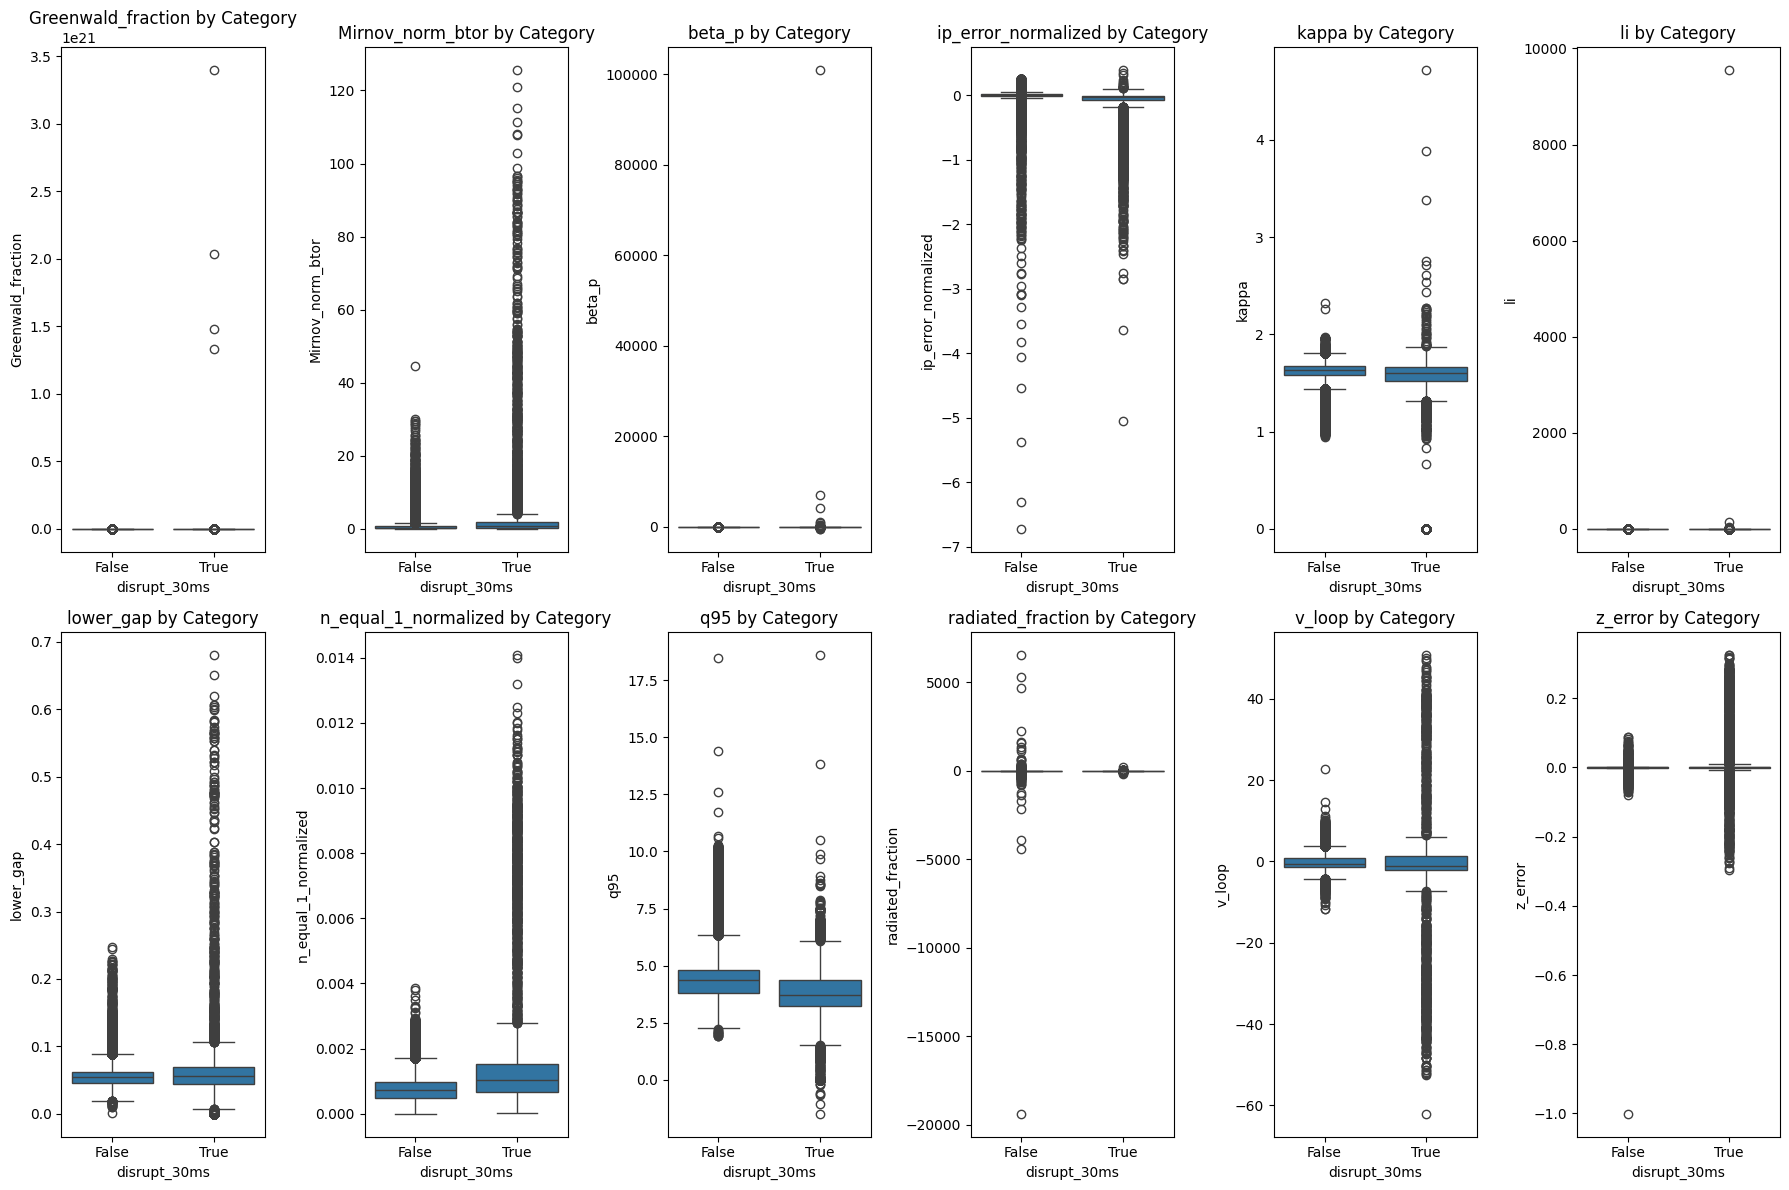

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

for index, feature in enumerate(df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(2, int(len(df.select_dtypes(include=[np.number]).columns)/2), index)
    sns.boxplot(x='disrupt_30ms', y=feature, data=df)
    plt.title(f'{feature} by Category')

plt.tight_layout()
plt.show()

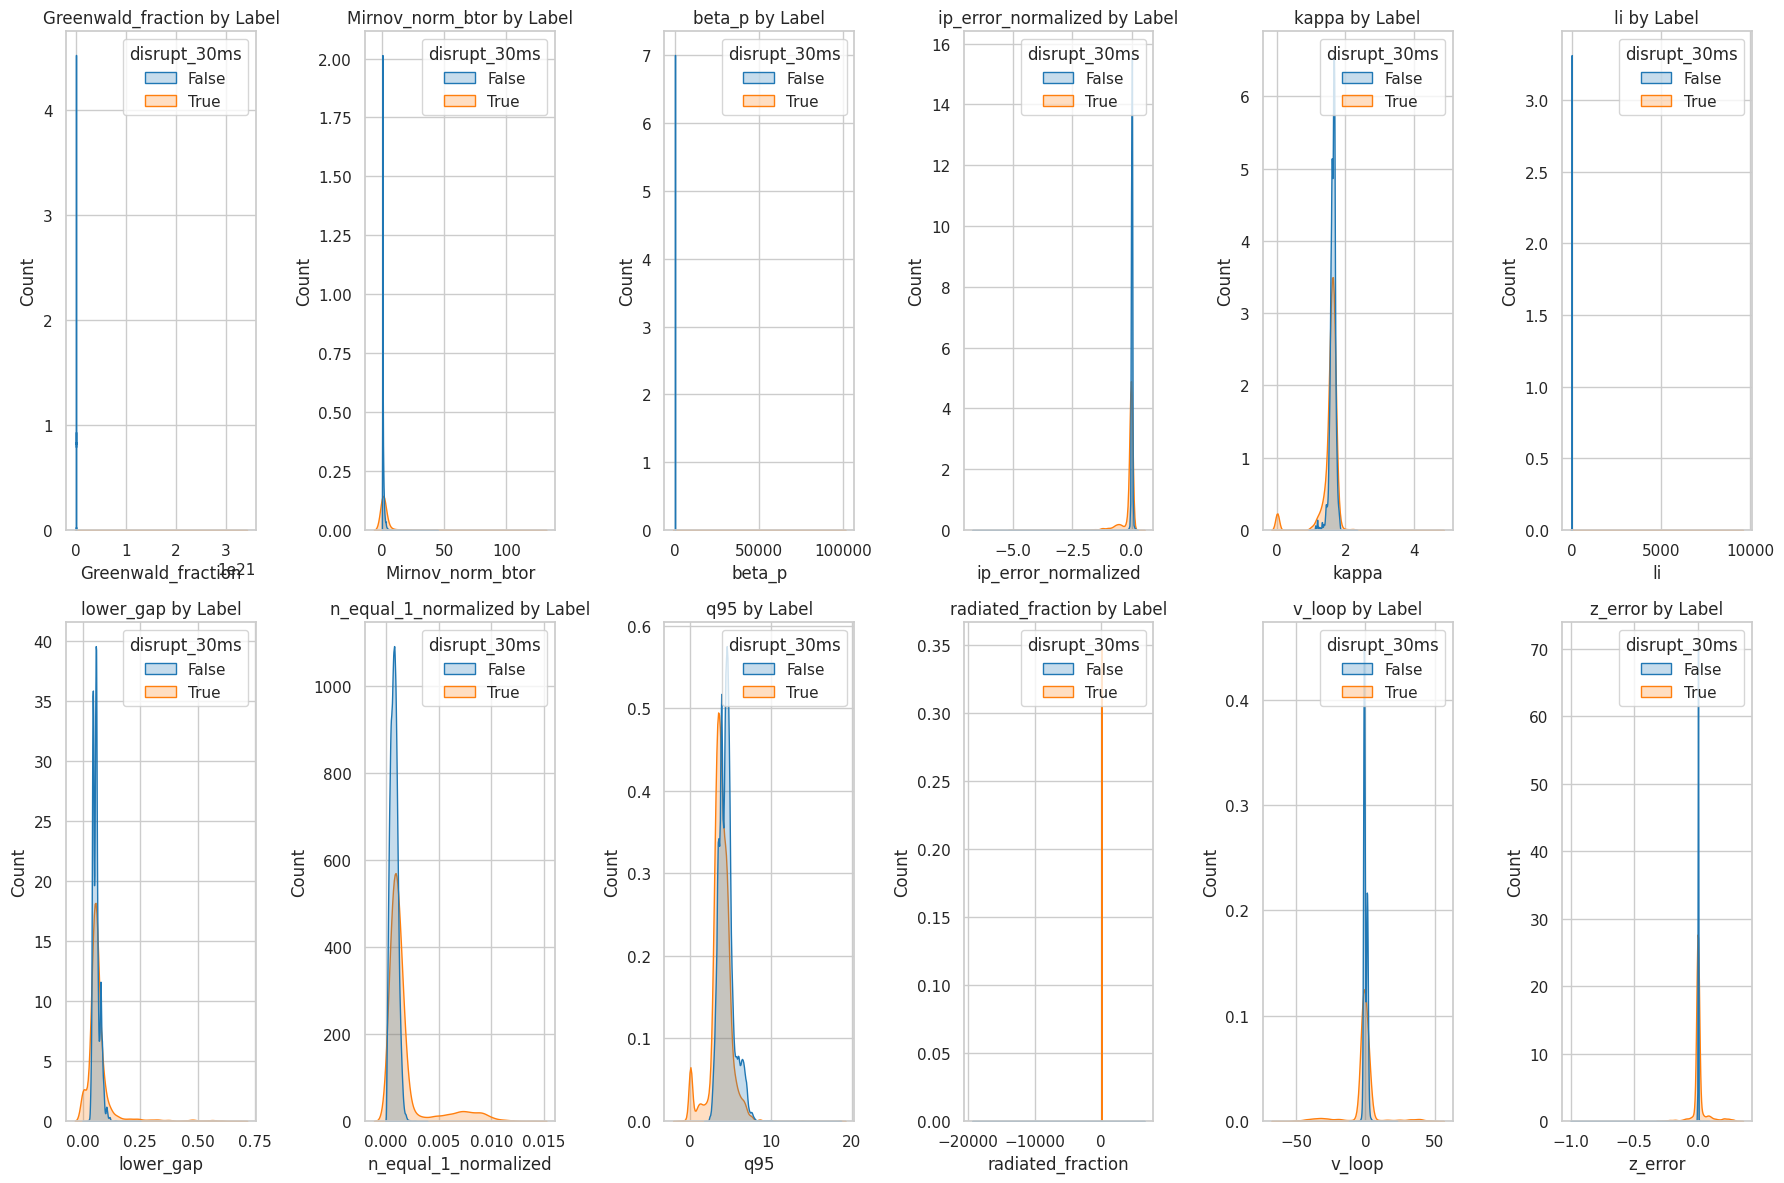

In [26]:
sns.set(style='whitegrid')
plt.figure(figsize=(18, 12))

numeric_columns = df.select_dtypes(include='number').columns
num_plots = len(numeric_columns)

for index, col in enumerate(numeric_columns, start=1):
    plt.subplot(2, int(num_plots/2), index)
    sns.kdeplot(data=df, x=col, hue='disrupt_30ms', fill=True, common_norm=False, palette='tab10')
    plt.title(f'{col} by Label')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
from sklearn.model_selection import train_test_split


In [28]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['disrupt_30ms'], random_state=42)

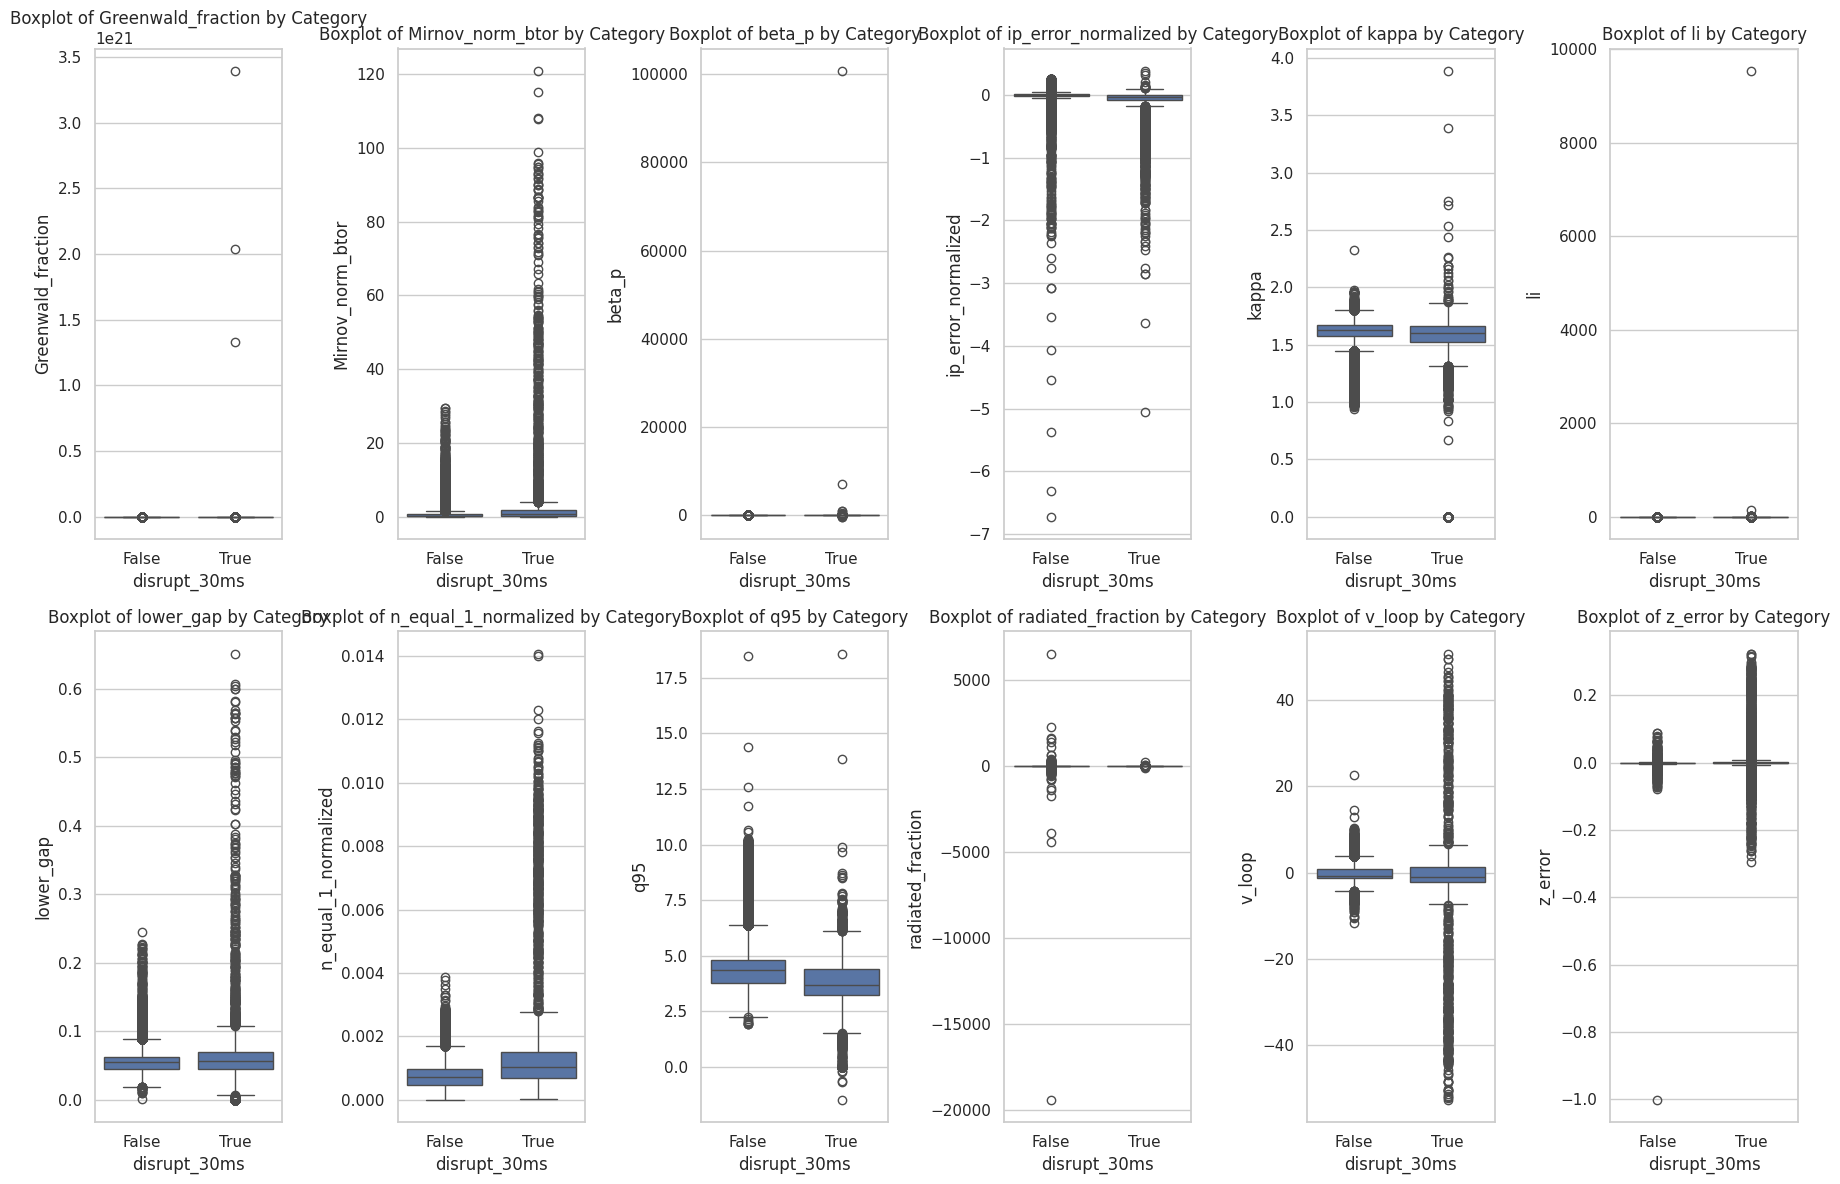

In [29]:
plt.figure(figsize=(18, 12))

for index, feature in enumerate(train_df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(2, int(len(train_df.select_dtypes(include=[np.number]).columns)/2), index)
    sns.boxplot(x='disrupt_30ms', y=feature, data=train_df)
    plt.title(f'Boxplot of {feature} by Category')

plt.tight_layout()
plt.show()

#Anomaly detection

In [30]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df.drop(columns=["disrupt_30ms"]))

In [31]:
isolation_forest = IsolationForest(max_samples=100, random_state=42)
isolation_forest.fit(scaled_data)

IsolationForest(max_samples=100, random_state=42)

In [32]:
# Predict anomalies: -1 indicates an anomaly, 1 indicates normal
y_pred = isolation_forest.predict(scaled_data)
print(y_pred)

[ 1  1  1 ...  1 -1  1]


In [33]:
y_train = train_df["disrupt_30ms"].copy()
print(y_train)

shot        time  
1160609020  1.0660    False
1140513013  1.3400    False
1140701030  1.0160    False
1150923011  1.3000    False
1140731003  0.6750    False
                      ...  
1150728017  0.8280    False
1160504012  0.8387    False
1160930007  1.4450    False
1160607030  1.1937    False
1160809019  0.6310    False
Name: disrupt_30ms, Length: 335041, dtype: bool


In [34]:
y_train[y_train==True]=-1
print(y_train)

shot        time  
1160609020  1.0660    False
1140513013  1.3400    False
1140701030  1.0160    False
1150923011  1.3000    False
1140731003  0.6750    False
                      ...  
1150728017  0.8280    False
1160504012  0.8387    False
1160930007  1.4450    False
1160607030  1.1937    False
1160809019  0.6310    False
Name: disrupt_30ms, Length: 335041, dtype: object


In [35]:
y_train[y_train==False]=1
print(y_train)

shot        time  
1160609020  1.0660    1
1140513013  1.3400    1
1140701030  1.0160    1
1150923011  1.3000    1
1140731003  0.6750    1
                     ..
1150728017  0.8280    1
1160504012  0.8387    1
1160930007  1.4450    1
1160607030  1.1937    1
1160809019  0.6310    1
Name: disrupt_30ms, Length: 335041, dtype: object


In [36]:
y_train=np.array(y_train,dtype='int64')
print(y_train)

[1 1 1 ... 1 1 1]


shot        time  
1160609020  1.0660    -1
1140513013  1.3400    -1
1140701030  1.0160    -1
1150923011  1.3000    -1
1140731003  0.6750    -1
                      ..
1150728017  0.8280    -1
1160504012  0.8387    -1
1160930007  1.4450    -1
1160607030  1.1937    -1
1160809019  0.6310    -1
Name: disrupt_30ms, Length: 335041, dtype: object

In [37]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
cm = confusion_matrix(y_train, y_pred, labels=[1, -1])



# Calculate precision and recall scores
precision = precision_score(y_train, y_pred, pos_label=-1)
recall = recall_score(y_train, y_pred, pos_label=-1)


# Display results
print("Confusion Matrix:")
print(cm)
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Display a full classification report
print("\nClassification Report:")
print(classification_report(y_train, y_pred, labels=[1, -1], target_names=['Normal', 'Anomalous']))

Confusion Matrix:
[[309947  20937]
 [  2269   1888]]

Precision: 0.08
Recall: 0.45

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.94      0.96    330884
   Anomalous       0.08      0.45      0.14      4157

    accuracy                           0.93    335041
   macro avg       0.54      0.70      0.55    335041
weighted avg       0.98      0.93      0.95    335041



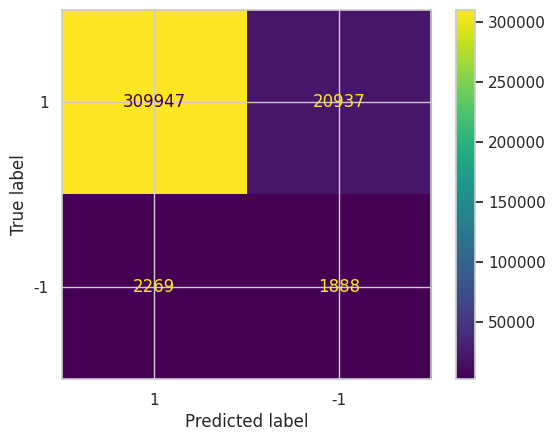

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,-1])
disp.plot()
plt.show()

In [52]:
y_train.dtype

dtype('O')

In [65]:
np.sum(y_pred[y_train==1])

0

In [40]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [47]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(train_df.drop(columns=["disrupt_30ms"]))

In [48]:
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:", explained_variance)


Explained Variance Ratio: [1.00000000e+00 5.90762925e-34]


In [50]:
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df.head()

,Principal Component 1,Principal Component 2
0,-2.018423e+16,0.037945
1,-2.018423e+16,-0.197858
2,-2.018423e+16,-0.143824
3,-2.018423e+16,-0.233500
4,-2.018423e+16,-0.202396


In [51]:
pca_df

,Principal Component 1,Principal Component 2
0,-2.018423e+16,0.037945
1,-2.018423e+16,-0.197858
2,-2.018423e+16,-0.143824
3,-2.018423e+16,-0.233500
4,-2.018423e+16,-0.202396
...,...,...
335036,-2.018423e+16,-0.287377
335037,-2.018423e+16,-0.436537
335038,-2.018423e+16,-0.115305
335039,-2.018423e+16,-0.263132


In [65]:
pca_df["disrupt_30ms"] = train_df["disrupt_30ms"].reset_index(drop=True)

# Plot the first two principal components with colors based on the label
plt.figure(figsize=(8, 6))
colors = {False: 'blue', True: 'red'}
#for label in pca_df["disrupt_30ms"].unique():
#    subset = pca_df[pca_df["disrupt_30ms"] == label]
#    plt.scatter(subset['Principal Component 1'], subset['Principal Component 2'], c=colors[label], label=label)

subset = pca_df[pca_df["disrupt_30ms"] == True]
plt.scatter(subset['Principal Component 1'], subset['Principal Component 2'], c=colors[True], label="True")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label')
plt.title('PCA Plot of First Two Components')
plt.grid(True)
plt.show()

KeyError: 'Principal Component 2'

<Figure size 800x600 with 0 Axes>

array([False,  True])

In [61]:
pca_df.drop(columns=["Principal Component 2"], inplace=True)
pca_df.head()

,Principal Component 1,disrupt_30ms
0,-2.018423e+16,False
1,-2.018423e+16,False
2,-2.018423e+16,False
3,-2.018423e+16,False
4,-2.018423e+16,False


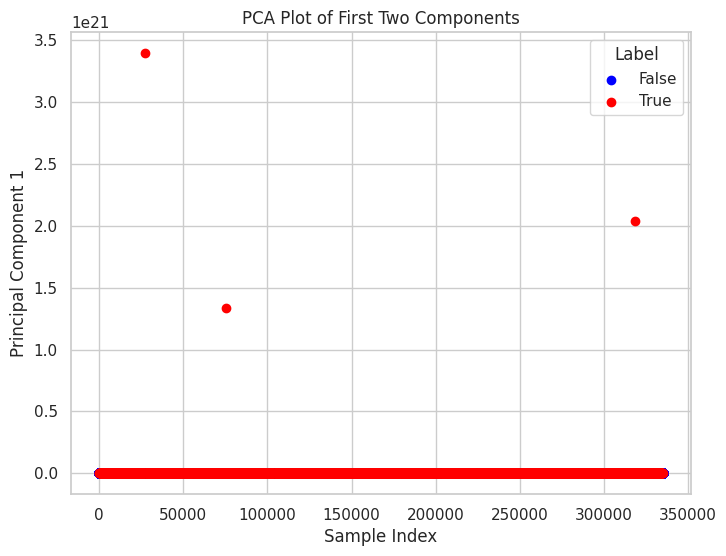

In [64]:
# Plot the first two principal components with colors based on the label
plt.figure(figsize=(8, 6))
colors = {False: 'blue', True: 'red'}
for label in pca_df["disrupt_30ms"].unique():
    subset = pca_df[pca_df["disrupt_30ms"] == label]
    plt.scatter(subset.index, subset['Principal Component 1'], c=colors[label], label=label)

plt.xlabel('Sample Index')
plt.ylabel('Principal Component 1')
plt.legend(title='Label')
plt.title('PCA Plot of First Two Components')
plt.grid(True)
plt.show()

In [66]:
df.head()

Greenwald_fraction  Mirnov_norm_btor    beta_p  \
shot       time                                                     
1150915029 0.2850        2.616714e-01          1.239055  0.147276   
           0.2900        1.936365e-01          1.153987  0.199118   
           0.2950        3.123977e-21          3.540942 -0.014039   
1120131006 0.1895        1.853891e-01          0.208537  0.001086   
           0.1945        1.804675e-01          0.194072  0.024498   

                   ip_error_normalized     kappa        li  lower_gap  \
shot       time                                                         
1150915029 0.2850            -0.155933  1.572284  1.440702   0.071738   
           0.2900            -0.214753  1.553859  1.470170   0.077982   
           0.2950            -0.660401  1.691133  1.032967   0.088654   
1120131006 0.1895            -0.264637  1.331522  1.553290   0.094562   
           0.1945            -0.246736  1.388904  1.564471   0.106611   

                   n_equal_1_normalized       q95  radiated_fraction  \
shot       time                                                        
1150915029 0.2850              0.000885  5.205303           0.408387   
           0.2900              0.001154  5.151639           1.701884   
           0.2950              0.003092  5.954643           0.276097   
1120131006 0.1895              0.001163  4.707932           0.665236   
           0.1945              0.001136  4.985343           0.510057   

                     v_loop   z_error  disrupt_30ms  
shot       time                                      
1150915029 0.2850  4.186112 -0.004279          True  
           0.2900  3.770813  0.000107          True  
           0.2950  7.111877  0.004702          True  
1120131006 0.1895 -2.671509 -0.007156          True  
           0.1945 -2.581421 -0.018531          True

In [67]:
df.groupby("disrupt_30ms").count()

,Greenwald_fraction,Mirnov_norm_btor,beta_p,ip_error_normalized,kappa,li,lower_gap,n_equal_1_normalized,q95,radiated_fraction,v_loop,z_error
disrupt_30ms,,,,,,,,,,,,
False,472692,472692,472692,472692,472692,472692,472692,472692,472692,472692,472692,472692
True,5938,5938,5938,5938,5938,5938,5938,5938,5938,5938,5938,5938


In [68]:
X=np.array(df.drop(["disrupt_30ms"],axis=1))

In [70]:
y = np.array(df["disrupt_30ms"])

In [71]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


In [77]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support


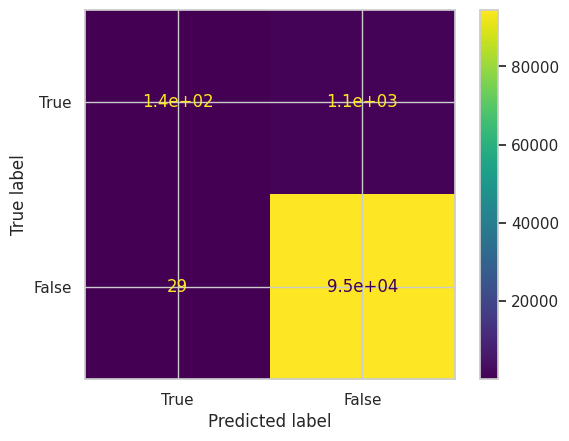

{'SVM': {'Fold_0': {True: {'Precision': 0.5932203389830508, 'Recall': 0.17676767676767677, 'FScore': 0.2723735408560311, 'Support': 1188}, False: {'Precision': 0.989745417942373, 'Recall': 0.9984768029786963, 'FScore': 0.9940919382865567, 'Support': 94538}}, 'Fold_1': {True: {'Precision': 1.0, 'Recall': 0.12962962962962962, 'FScore': 0.22950819672131148, 'Support': 1188}, False: {'Precision': 0.9891809316536224, 'Recall': 1.0, 'FScore': 0.9945610436063332, 'Support': 94538}}, 'Fold_2': {True: {'Precision': 0.9827586206896551, 'Recall': 0.14393939393939395, 'FScore': 0.2511013215859031, 'Support': 1188}, False: {'Precision': 0.9893565807099799, 'Recall': 0.9999682667287229, 'FScore': 0.9946341206796782, 'Support': 94538}}, 'Fold_3': {True: {'Precision': 1.0, 'Recall': 0.12299915754001685, 'FScore': 0.21905476369092272, 'Support': 1187}, False: {'Precision': 0.9891086001255492, 'Recall': 1.0, 'FScore': 0.994524482034936, 'Support': 94539}}, 'Fold_4': {True: {'Precision': 1.0, 'Recall': 0

In [78]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = [True,False]
results={"SVM":{}}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y[train_index]
  x_test = X[test_index]
  y_test = y[test_index]
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["SVM"][fold]={}
  for j in range(len(labels)):
    results["SVM"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)

In [74]:


clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = ["anomaly","no-anomaly"]
results_m={"SVM":{}}
cm=np.zeros((5,len(labels),len(labels)))

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = ym[train_index]
  x_test = X[test_index]
  y_test = ym[test_index]
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["SVM"][fold]={}
  for j in range(len(labels)):
    results_m["SVM"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)


NameError: name 'ym' is not defined

In [ ]:
recalls_m={"SVM":[]}
for key in results_m["SVM"]:
  recalls_m["SVM"].append(results_m["SVM"][key]["fail"]["Recall"])

In [ ]:
recalls_m

{'SVM': [0.5,
  0.6818181818181818,
  0.5454545454545454,
  0.5454545454545454,
  0.6086956521739131]}

In [79]:
from imblearn.over_sampling import SMOTE

In [80]:
resampler = SMOTE(sampling_strategy="not majority", random_state=42)

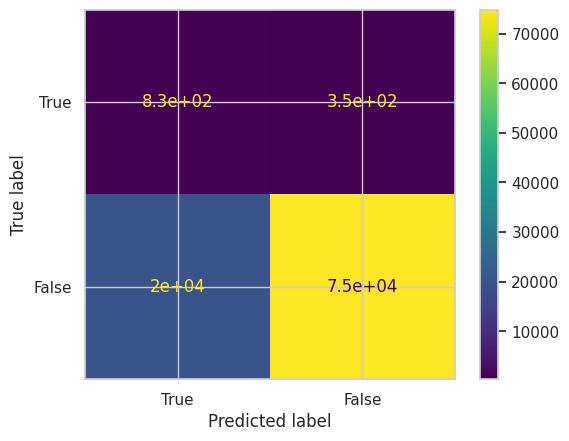

{'SVM': {'Fold_0': {True: {'Precision': 0.5932203389830508, 'Recall': 0.17676767676767677, 'FScore': 0.2723735408560311, 'Support': 1188}, False: {'Precision': 0.989745417942373, 'Recall': 0.9984768029786963, 'FScore': 0.9940919382865567, 'Support': 94538}}, 'Fold_1': {True: {'Precision': 1.0, 'Recall': 0.12962962962962962, 'FScore': 0.22950819672131148, 'Support': 1188}, False: {'Precision': 0.9891809316536224, 'Recall': 1.0, 'FScore': 0.9945610436063332, 'Support': 94538}}, 'Fold_2': {True: {'Precision': 0.9827586206896551, 'Recall': 0.14393939393939395, 'FScore': 0.2511013215859031, 'Support': 1188}, False: {'Precision': 0.9893565807099799, 'Recall': 0.9999682667287229, 'FScore': 0.9946341206796782, 'Support': 94538}}, 'Fold_3': {True: {'Precision': 1.0, 'Recall': 0.12299915754001685, 'FScore': 0.21905476369092272, 'Support': 1187}, False: {'Precision': 0.9891086001255492, 'Recall': 1.0, 'FScore': 0.994524482034936, 'Support': 94539}}, 'Fold_4': {True: {'Precision': 1.0, 'Recall': 0

NameError: name 'recalls' is not defined

In [81]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
results["SVM_RES"]={}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y[train_index]
  x_test = X[test_index]
  y_test = y[test_index]
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  clf.fit(x_res, y_res)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["SVM_RES"][fold]={}
  for j in range(len(labels)):
    results["SVM_RES"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)
recalls["SVM_RES"]=[]
#for key in results["SVM_RES"]:
#  recalls["SVM_RES"].append(results["SVM_RES"][key]["fail"]["Recall"])